In [1]:
from CLEAN.infer import infer_pvalue

test_data = "new"
train_data = "split100"
infer_pvalue(train_data, test_data, p_value=1e-5, nk_random=20, report_metrics=True, pretrained=True)

/home/seyonec/.conda/envs/clean/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([392, 128])


100%|██████████| 5242/5242 [00:00<00:00, 27790.19it/s]


Calculating eval distance map, between 392 test ids and 5242 train EC cluster centers


392it [00:00, 1002.13it/s]
100%|██████████| 5242/5242 [00:00<00:00, 38467.94it/s]
20000it [00:15, 1292.98it/s]
100%|██████████| 392/392 [00:09<00:00, 43.54it/s]


############ EC calling results using random chosen 20k samples ############
---------------------------------------------------------------------------
>>> total samples: 392 | total ec: 177 
>>> precision: 0.558 | recall: 0.477| F1: 0.482 | AUC: 0.737 
---------------------------------------------------------------------------


In [2]:
## Similar code to the selection methods, except we just want to extract the raw euclidean distance maps for any pair of train and test data
import torch
from CLEAN.utils import * 
from CLEAN.model import LayerNormNet
from CLEAN.distance_map import *
from CLEAN.evaluate import *
import pandas as pd
import warnings

def get_eval_dist_map(train_data, test_data, pretrained=True, model_name=None):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    dtype = torch.float32
    id_ec_train, ec_id_dict_train = get_ec_id_dict('./data/' + train_data + '.csv')
    id_ec_test, _ = get_ec_id_dict('./data/' + test_data + '.csv')
    # load checkpoints
    # NOTE: change this to LayerNormNet(512, 256, device, dtype) 
    # and rebuild with [python build.py install]
    # if inferencing on model trained with supconH loss
    model = LayerNormNet(512, 128, device, dtype)
    
    if pretrained:
        try:
            checkpoint = torch.load('./data/pretrained/'+ train_data +'.pth', map_location=device)
        except FileNotFoundError as error:
            raise Exception('No pretrained weights for this training data')
    else:
        try:
            checkpoint = torch.load('./data/model/'+ model_name +'.pth', map_location=device)
        except FileNotFoundError as error:
            raise Exception('No model found!')
        
    model.load_state_dict(checkpoint)
    model.eval()
    # load precomputed EC cluster center embeddings if possible
    if train_data == "split70":
        emb_train = torch.load('./data/pretrained/70.pt', map_location=device)
    elif train_data == "split100":
        emb_train = torch.load('./data/pretrained/100.pt', map_location=device)
    else:
        emb_train = model(esm_embedding(ec_id_dict_train, device, dtype))
        
    emb_test = model_embedding_test(id_ec_test, model, device, dtype)
    eval_dist = get_dist_map_test(emb_train, emb_test, ec_id_dict_train, id_ec_test, device, dtype)
    seed_everything()

    return eval_dist

In [3]:
eval_dist = get_eval_dist_map(train_data, test_data, pretrained=True)

true_label, all_label = get_true_labels('./data/' + test_data)


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([392, 128])


100%|██████████| 5242/5242 [00:00<00:00, 29275.38it/s]


Calculating eval distance map, between 392 test ids and 5242 train EC cluster centers


392it [00:00, 1219.90it/s]


In [ ]:
# get keys of dict as list
test_ids = list(eval_dist.keys())

# each key in the dictionary is a dictionary, and we want to sort the sub-dictionary based on the values of the keys ascending
sorted_dict = {key: dict(sorted(eval_dist[key].items(), key=lambda item: item[1])) for key in eval_dist}


In [ ]:
## Create two numpy arrays, one for the keys and one for the values, of size (len(test_ids), # of keys in the sub-dictionary)
## Go through each key in sorted_dict,
## For each key, go through each key in the sub-dictionary and get the key value pair
## Append the key to the keys array and the value to the values array
import numpy as np

## init 2d np arrays with 0's

## np array of EC_ids (strings)
#EC_ids = np.zeros((len(test_ids), len(sorted_dict[test_ids[0]]))
dists = np.zeros((len(test_ids), len(sorted_dict[test_ids[0]])))
for i, key in enumerate(sorted_dict):
    j = 0
    for k, v in sorted_dict[key].items():
        dists[i][j] = v
        j += 1


In [ ]:
import numpy as np
# find first index where element dists[0] is not ascedning
def find_non_ascending_row(arr):
    for i in range(arr.shape[0]):
        if not np.all(np.diff(arr[i]) >= 0):
            return i
    return -1  # Return -1 if all rows are ascending

# Example usage
non_ascending_row_index = find_non_ascending_row(dists)
print(non_ascending_row_index)


In [ ]:
# save sorted_dict
import pickle
with open('/home/seyonec/protein-conformal/clean_selection/sorted_dict.pkl', 'wb') as f:
    pickle.dump(sorted_dict, f)

# save dists
with open('/home/seyonec/protein-conformal/clean_selection/dists.pkl', 'wb') as f:
    pickle.dump(dists, f)

# dump true labels
with open('/home/seyonec/protein-conformal/clean_selection/true_labels.pkl', 'wb') as f:
    pickle.dump(true_label, f)

## get distance maps for Price

In [1]:
from CLEAN.infer import infer_pvalue

test_data = "price"
train_data = "split100"
infer_pvalue(train_data, test_data, p_value=1e-5, nk_random=20, report_metrics=True, pretrained=True)

/home/seyonec/.conda/envs/clean/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:11<00:00, 438.04it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 419.62it/s]
100%|██████████| 5242/5242 [00:11<00:00, 437.35it/s]
20000it [00:47, 421.44it/s]
100%|██████████| 149/149 [00:02<00:00, 52.90it/s]


############ EC calling results using random chosen 20k samples ############
---------------------------------------------------------------------------
>>> total samples: 149 | total ec: 56 
>>> precision: 0.593 | recall: 0.447| F1: 0.478 | AUC: 0.723 
---------------------------------------------------------------------------


In [4]:
from CLEAN.distance_map import *
from CLEAN.evaluate import *
train_data = "split100"

price_eval_dist = get_eval_dist_map(train_data, "price", pretrained=True)
price_eval_df = pd.DataFrame.from_dict(price_eval_dist)
price_eval_np = price_eval_df.values

new_eval_dist = get_eval_dist_map(train_data, "new", pretrained=True)
new_eval_df = pd.DataFrame.from_dict(new_eval_dist)
new_eval_np = new_eval_df.values



The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


 51%|█████     | 2651/5242 [00:05<00:05, 476.70it/s]

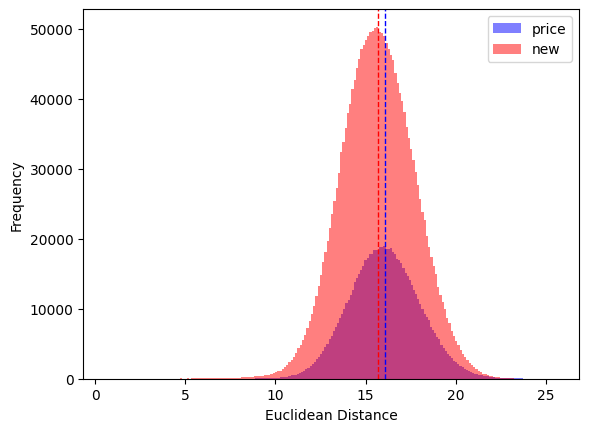

<Figure size 640x480 with 0 Axes>

In [9]:
## flatten distances from 2d numpy array into 1d and visualize histogram of scores
import matplotlib.pyplot as plt
plt.hist(price_eval_np.flatten(), bins=200, alpha=0.5, label='price', color = "blue")
plt.hist(new_eval_np.flatten(), bins=200, alpha=0.5, label='new', color = "red")
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
# plot dashed lines for price, new mean siilarity
plt.axvline(price_eval_np.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(new_eval_np.mean(), color='red', linestyle='dashed', linewidth=1)
plt.legend()
plt.savefig("CLEAN_new_price_similarity_histogram.pdf")
plt.show()

In [16]:
## print out medians, min, max, mean of both flatten arrays
print("Price eval median:", np.median(price_eval_np))
print("New eval median:", np.median(new_eval_np))
print("Price eval min:", np.min(price_eval_np))
print("New eval min:", np.min(new_eval_np))
print("Price eval max:", np.max(price_eval_np))
print("New eval max:", np.max(new_eval_np))
print("Price eval mean:", np.mean(price_eval_np))
print("New eval mean:", np.mean(new_eval_np))


Price eval median: 16.022476
New eval median: 15.660578
Price eval min: 2.056845
New eval min: 0.5889817
Price eval max: 25.48286
New eval max: 25.598625
Price eval mean: 16.05319
New eval mean: 15.680931


In [4]:
from CLEAN.infer import infer_pvalue

test_data = "price"
train_data = "split100"


In [5]:
eval_dist = get_eval_dist_map(train_data, test_data, pretrained=True)

true_label, all_label = get_true_labels('./data/' + test_data)


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:00<00:00, 40647.32it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 1462.89it/s]


In [6]:
# get keys of dict as list
test_ids = list(eval_dist.keys())

# each key in the dictionary is a dictionary, and we want to sort the sub-dictionary based on the values of the keys ascending
sorted_dict = {key: dict(sorted(eval_dist[key].items(), key=lambda item: item[1])) for key in eval_dist}


In [7]:
## Create two numpy arrays, one for the keys and one for the values, of size (len(test_ids), # of keys in the sub-dictionary)
## Go through each key in sorted_dict,
## For each key, go through each key in the sub-dictionary and get the key value pair
## Append the key to the keys array and the value to the values array
import numpy as np

## init 2d np arrays with 0's

## np array of EC_ids (strings)
#EC_ids = np.zeros((len(test_ids), len(sorted_dict[test_ids[0]]))
dists = np.zeros((len(test_ids), len(sorted_dict[test_ids[0]])))
for i, key in enumerate(sorted_dict):
    j = 0
    for k, v in sorted_dict[key].items():
        dists[i][j] = v
        j += 1


import numpy as np
# find first index where element dists[0] is not ascedning
def find_non_ascending_row(arr):
    for i in range(arr.shape[0]):
        if not np.all(np.diff(arr[i]) >= 0):
            return i
    return -1  # Return -1 if all rows are ascending

# Example usage
non_ascending_row_index = find_non_ascending_row(dists)
print(non_ascending_row_index)


-1


In [8]:
# save sorted_dict
import pickle
with open('/home/seyonec/protein-conformal/clean_selection/price_sorted_dict.pkl', 'wb') as f:
    pickle.dump(sorted_dict, f)

# save dists
with open('/home/seyonec/protein-conformal/clean_selection/price_dists.pkl', 'wb') as f:
    pickle.dump(dists, f)

# dump true labels
with open('/home/seyonec/protein-conformal/clean_selection/price_true_labels.pkl', 'wb') as f:
    pickle.dump(true_label, f)

## Get distance maps, etc for ESM-1B

In [2]:
from CLEAN.utils import ensure_dirs, get_ec_id_dict, format_esm
from CLEAN.distance_map import get_dist_map_test
import torch
import pickle

def load_esm(lookup):
    esm = format_esm(torch.load('/data/seyonec/CLEAN/app/data/esm_data/' + lookup + '.pt'))
    return esm.unsqueeze(0)

def esm_embedding(ec_id_dict, device, dtype):
    '''
    Loading esm embedding in the sequence of EC numbers
    prepare for calculating cluster center by EC
    '''
    esm_emb = []
    # for ec in tqdm(list(ec_id_dict.keys())):
    for ec in list(ec_id_dict.keys()):
        ids_for_query = list(ec_id_dict[ec])
        esm_to_cat = [load_esm(id) for id in ids_for_query]
        esm_emb = esm_emb + esm_to_cat
    return torch.cat(esm_emb).to(device=device, dtype=dtype)

def esm_embedding_test(id_ec_test, device, dtype):
    '''
    Instead of loading esm embedding in the sequence of EC numbers
    the test embedding is loaded in the sequence of queries
    then inferenced with model to get model embedding
    '''
    ids_for_query = list(id_ec_test.keys())
    esm_to_cat = [load_esm(id) for id in ids_for_query]
    esm_emb = torch.cat(esm_to_cat).to(device=device, dtype=dtype)
    #model_emb = model(esm_emb)
    return esm_emb


def compute_esm_distance(train_file, test_file):
    ensure_dirs('./data/distance_map/')
    _, ec_id_dict_train = get_ec_id_dict('./data/' + train_file + '.csv')
    id_ec_test, _ = get_ec_id_dict('./data/' + test_file + '.csv')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    dtype = torch.float32
    esm_emb_train = esm_embedding(ec_id_dict_train, device, dtype)
    esm_emb_test = esm_embedding_test(id_ec_test, device, dtype)
    eval_dist = get_dist_map_test(esm_emb_train, esm_emb_test, ec_id_dict_train, id_ec_test, device, dtype)

    pickle.dump(eval_dist, open('./data/distance_map/' + test_file + "_" + train_file + '.pkl', 'wb'))
    #pickle.dump(esm_emb_train, open('./data/distance_map/' + train_file + '_esm.pkl', 'wb'))
    #pickle.dump(esm_emb_test, open('./data/distance_map/' + test_file + '_esm.pkl', 'wb'))



/home/seyonec/.conda/envs/clean/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
compute_esm_distance("split100", "price")

The embedding sizes for train and test: torch.Size([241025, 1280]) torch.Size([149, 1280])


100%|██████████| 5242/5242 [00:00<00:00, 40786.74it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 1260.33it/s]


In [16]:
compute_esm_distance("split100", "new")

The embedding sizes for train and test: torch.Size([241025, 1280]) torch.Size([392, 1280])


100%|██████████| 5242/5242 [00:00<00:00, 40062.21it/s]


Calculating eval distance map, between 392 test ids and 5242 train EC cluster centers


392it [00:00, 1253.27it/s]


In [17]:
esm_price_dists = pickle.load(open('./data/distance_map/price_split100.pkl', 'rb'))


In [5]:
from CLEAN.evaluate import get_true_labels

def get_sorted_dict(test_file, dict_dists):
    import numpy as np
    true_label, all_label = get_true_labels('./data/' + test_file)
    # get keys of dict as list
    test_ids = list(dict_dists.keys())

    # each key in the dictionary is a dictionary, and we want to sort the sub-dictionary based on the values of the keys ascending
    sorted_dict = {key: dict(sorted(dict_dists[key].items(), key=lambda item: item[1])) for key in dict_dists}

    ## Create two numpy arrays, one for the keys and one for the values, of size (len(test_ids), # of keys in the sub-dictionary)
    ## Go through each key in sorted_dict,
    ## For each key, go through each key in the sub-dictionary and get the key value pair
    ## Append the key to the keys array and the value to the values array

    ## init 2d np arrays with 0's

    ## np array of EC_ids (strings)
    #EC_ids = np.zeros((len(test_ids), len(sorted_dict[test_ids[0]]))
    dists = np.zeros((len(test_ids), len(sorted_dict[test_ids[0]])))
    for i, key in enumerate(sorted_dict):
        j = 0
        for k, v in sorted_dict[key].items():
            dists[i][j] = v
            j += 1


    import numpy as np
    # find first index where element dists[0] is not ascedning
    def find_non_ascending_row(arr):
        for i in range(arr.shape[0]):
            if not np.all(np.diff(arr[i]) >= 0):
                return i
        return -1  # Return -1 if all rows are ascending

    # Example usage
    non_ascending_row_index = find_non_ascending_row(dists)
    print(non_ascending_row_index)

    return sorted_dict, dists, true_label


/home/seyonec/.conda/envs/clean/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
sorted_dict_price, dists_price, true_label_price = get_sorted_dict("price", esm_price_dists)

-1


In [36]:
esm_new_dists = pickle.load(open('./data/distance_map/new_split100.pkl', 'rb'))

sorted_dict_new, dists_new, true_label_new = get_sorted_dict("new", esm_new_dists)

-1


In [37]:
import pickle
with open('/home/seyonec/protein-conformal/clean_selection/esm_price_sorted_dict.pkl', 'wb') as f:
    pickle.dump(sorted_dict_price, f)

# save dists
with open('/home/seyonec/protein-conformal/clean_selection/esm_price_dists.pkl', 'wb') as f:
    pickle.dump(dists_price, f)

# dump true labels
with open('/home/seyonec/protein-conformal/clean_selection/esm_price_true_labels.pkl', 'wb') as f:
    pickle.dump(true_label_price, f)

with open('/home/seyonec/protein-conformal/clean_selection/esm_new_sorted_dict.pkl', 'wb') as f:
    pickle.dump(sorted_dict_new, f)

# save dists
with open('/home/seyonec/protein-conformal/clean_selection/esm_new_dists.pkl', 'wb') as f:
    pickle.dump(dists_new, f)

# dump true labels
with open('/home/seyonec/protein-conformal/clean_selection/esm_new_true_labels.pkl', 'wb') as f:
    pickle.dump(true_label_new, f)

In [ ]:
get_sorted_dict("new", esm_new_dists)

## generate a train sequences vs train EC cluster centers distance map

In [13]:
compute_esm_distance("split100", "split100")

The embedding sizes for train and test: torch.Size([241025, 1280]) torch.Size([227362, 1280])


100%|██████████| 5242/5242 [00:00<00:00, 40584.14it/s]


Calculating eval distance map, between 227362 test ids and 5242 train EC cluster centers


227362it [03:10, 1194.41it/s]


In [4]:
id_ec_test, _ = get_ec_id_dict('./data/' + "split100" + '.csv')


In [9]:
len(id_ec_test.keys())

227362

In [2]:
import pickle as pkl

with open('/home/seyonec/protein-conformal/clean_selection/data/distance_map/split100_split100.pkl', 'rb') as f:
    esm_dists_split100 = pkl.load(f)


In [3]:
# convert keys of dict to list
test_ids = list(esm_dists_split100.keys())


In [7]:
sorted_dict_split, dists_split, true_label_split = get_sorted_dict("split100", esm_dists_split100)

In [ ]:
with open('/home/seyonec/protein-conformal/clean_selection/esm_split100_sorted_dict.pkl', 'wb') as f:
    pkl.dump(sorted_dict_split, f)


In [ ]:
# save dists
with open('/home/seyonec/protein-conformal/clean_selection/esm_split100_dists.pkl', 'wb') as f:
    pkl.dump(dists_split, f)



In [ ]:
# dump true labels
with open('/home/seyonec/protein-conformal/clean_selection/esm_split100_true_labels.pkl', 'wb') as f:
    pkl.dump(true_label_split, f)

